In [1]:
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


import numpy as np
from numpy import random
import matplotlib.pyplot as plt
# import autokeras as ak
import os 
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
        
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

logging.info("numpy Version is {}".format(np.__version__))
# logging.info("autokeras Version is {}".format(ak.__version__))
logging.info("tensorflow Version is {}".format(tf.keras.__version__))
logging.info("\n")

!nvidia-smi

INFO:root:numpy Version is 1.19.5
INFO:root:tensorflow Version is 2.4.0
INFO:root:



1 Physical GPUs, 1 Logical GPU
Wed Oct  6 07:40:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM-80GB       On   | 00000000:4C:00.0 Off |                    0 |
| N/A   34C    P0   102W / 400W |  68880MiB / 81251MiB |     99%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                         

In [3]:
%%time
#Load Model
experiment = "dune"

model_theta23 = { "dropuot_rate_0": 0,}
model_delta = { "dropuot_rate_0": 0,}
for i in range(10):
    model_theta23.update({"dropuot_rate_"+str(i): 0}) 
    model_delta.update({"dropuot_rate_"+str(i): 0}) 
                      
        

for i, dropuot_rate in enumerate(model_theta23):
    
    file_path = "/dicos_ui_home/alanchung/ML4NO/Dropout_Study/Model/" + str(experiment) + "_" + "theta23" + "_" + str(i) + "_dropout_standardized.h5"
    
    if os.path.isfile(file_path):
        
        logging.info(str(file_path) +" exists.")

        model_theta23[dropuot_rate] = load_model(file_path)

    else:
        logging.info("Please Check Input Files!!!")
        raise ValueError("Please Check Input Files!!!")

logging.info("\n")
        
for i, dropuot_rate in enumerate(model_delta):
    
    file_path = "/dicos_ui_home/alanchung/ML4NO/Dropout_Study/Model/" + str(experiment) + "_" + "delta" + "_" + str(i) + "_dropout_standardized.h5"
    
    if os.path.isfile(file_path):
        
        logging.info(str(file_path) +" exists.")

        model_delta[dropuot_rate] = load_model(file_path)

    else:
        logging.info("Please Check Input Files!!!")
        raise ValueError("Please Check Input Files!!!")
        
if model_theta23["dropuot_rate_0"] != 0 and model_delta["dropuot_rate_0"] != 0:
    logging.info("\n")
    model_theta23["dropuot_rate_0"].summary()
    logging.info("\n")
    model_delta["dropuot_rate_0"].summary()
else:
    pass
    
logging.info("\n")
logging.info("All Models are loaded!")

INFO:root:/dicos_ui_home/alanchung/ML4NO/Dropout_Study/Model/dune_theta23_0_dropout_standardized.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Dropout_Study/Model/dune_theta23_1_dropout_standardized.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Dropout_Study/Model/dune_theta23_2_dropout_standardized.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Dropout_Study/Model/dune_theta23_3_dropout_standardized.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Dropout_Study/Model/dune_theta23_4_dropout_standardized.h5 exists.
INFO:root:Please Check Input Files!!!


ValueError: Please Check Input Files!!!

In [3]:
%%time
test_data = np.load('../Data/sample_NuFit0911.npz')
data_mid = np.column_stack([test_data["ve_"+str(experiment)], test_data["vu_"+str(experiment)], test_data["vebar_"+str(experiment)], test_data["vubar_"+str(experiment)]])
# data_mid = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
# data_mid = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune'],data['ve_t2hk'], data['vu_t2hk'], data['vebar_t2hk'], data['vubar_t2hk']])
data_IO_mid = data_mid[0]
data_NO_mid = data_mid[1]


CPU times: user 3.03 ms, sys: 444 µs, total: 3.47 ms
Wall time: 3.28 ms


In [4]:
%%time
N = 10000#00



IO_or_NO = 0 # 0 for IO and 1 for NO


if IO_or_NO == 0:
    logging.info("IO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][0], test_data['delta'][0]))
    
    data_asimov = data_IO_mid.reshape(1,264)
    data_poisson = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
    
    """
    Standardization
    """
    standardize = load("./Standardization.h5")
    data_poisson = standardize.transform(data_poisson)
    data_asimov = standardize.transform(data_asimov)
    
else:
    logging.info("NO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][1], test_data['delta'][1]))
    
    data_asimov = data_NO_mid.reshape(1,264)
    data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
    
    """
    Standardization
    """
    standardize = load("./Standardization.h5")
    data_poisson = standardize.transform(data_poisson)
    data_asimov = standardize.transform(data_asimov)



INFO:root:IO
INFO:root:True point: theta_23 = 49.00 \delta_cp = 195.00


CPU times: user 357 ms, sys: 2.15 ms, total: 359 ms
Wall time: 358 ms


In [15]:
%%time

def Contour(resolution_dictinary, model_dictinary, bin_size):

    for i, dropuot_rate in enumerate(tqdm(resolution_dictinary)):

        prediction_asimov = model_dictinary[dropuot_rate].predict(data_asimov)[0][0]
        tmp = model_dictinary[dropuot_rate].predict(data_poisson)[:,0]
        hist, bin_edges = np.histogram(tmp, bins = bin_size)
        max_poi = np.where(hist == hist.max())

        """
        left boundary
        """
        tot_event_num = hist.sum()
        left_area = 0
        for left_boundary in range(len(hist)):
            left_area += hist[left_boundary]
            if left_area/tot_event_num >= 0.34:
                break

        left_boundary = bin_edges[left_boundary]

        """
        right boundary
        """
        tot_event_num = hist.sum()
        right_area = 0
        for right_boundary in np.linspace(len(hist)-1,0,len(hist)):
            right_area += hist[int(right_boundary)]
            if right_area/tot_event_num >= 0.34:
                break

        right_boundary = bin_edges[int(right_boundary)]
        
        logging.info("\n")
        logging.info(i)
        logging.info("prediction asimov: {:.1f}".format(prediction_asimov))
        logging.info("right_boundary: {:.1f}".format(right_boundary))
        logging.info("best fit: {:.1f}".format(bin_edges[max_poi][0]))
        logging.info("left_boundary: {:.1f}".format(left_boundary))
        logging.info("################")
        logging.info("\n")

        resolution_dictinary[dropuot_rate]["asimov"] = prediction_asimov
        resolution_dictinary[dropuot_rate]["hist"] = hist
        resolution_dictinary[dropuot_rate]["best_fit"] = bin_edges[max_poi][0]
        resolution_dictinary[dropuot_rate]["p_yerr"] = right_boundary
        resolution_dictinary[dropuot_rate]["n_yerr"] = left_boundary
    
    return resolution_dictinary
    
    
    

theta23_resolution = { "dropuot_rate_0": {"asimov": 0, "hist": 0, "best_fit": 0, "p_yerr": 0 , "n_yerr": 0 , },}
delta_resolution = { "dropuot_rate_0": {"asimov": 0, "hist": 0, "best_fit": 0, "p_yerr": 0 , "n_yerr": 0 , },}

for i in range(10):
    theta23_resolution.update({"dropuot_rate_"+str(i): {"asimov": 0, "hist": 0, "best_fit": 0, "p_yerr": 0 , "n_yerr": 0 , },}) 
    delta_resolution.update({"dropuot_rate_"+str(i): {"asimov": 0, "hist": 0, "best_fit": 0, "p_yerr": 0 , "n_yerr": 0 , },}) 

    
    
bins_theta23 = np.linspace(38.9, 51.1, 1000)
# bins_theta23 = np.linspace(0, 360, 1000000)
theta23_resolution = Contour(theta23_resolution, model_theta23, bins_theta23)
        
bins_delta = np.linspace(0, 360, 1000)
delta_resolution = Contour(delta_resolution, model_delta, bins_delta)
    
    

  0%|          | 0/10 [00:00<?, ?it/s]INFO:root:

INFO:root:0
INFO:root:prediction asimov: 49.1
INFO:root:right_boundary: 47.4
INFO:root:best fit: 43.3
INFO:root:left_boundary: 43.7
INFO:root:################
INFO:root:

 10%|█         | 1/10 [00:01<00:10,  1.12s/it]INFO:root:

INFO:root:1
INFO:root:prediction asimov: 48.6
INFO:root:right_boundary: 46.4
INFO:root:best fit: 49.8
INFO:root:left_boundary: 40.9
INFO:root:################
INFO:root:

 20%|██        | 2/10 [00:02<00:09,  1.13s/it]INFO:root:

INFO:root:2
INFO:root:prediction asimov: 48.4
INFO:root:right_boundary: 45.5
INFO:root:best fit: 41.7
INFO:root:left_boundary: 42.5
INFO:root:################
INFO:root:

 30%|███       | 3/10 [00:03<00:07,  1.13s/it]INFO:root:

INFO:root:3
INFO:root:prediction asimov: 47.7
INFO:root:right_boundary: 43.6
INFO:root:best fit: 39.3
INFO:root:left_boundary: 40.5
INFO:root:################
INFO:root:

 40%|████      | 4/10 [00:04<00:06,  1.13s/it]INFO:root:

INFO:root:4
INFO:root:prediction a

CPU times: user 7.45 s, sys: 1.3 s, total: 8.75 s
Wall time: 22.4 s


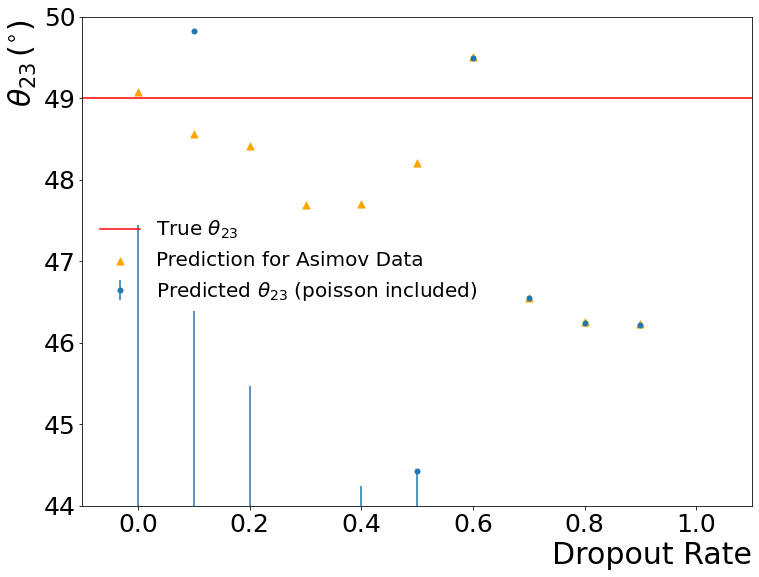

CPU times: user 243 ms, sys: 163 ms, total: 406 ms
Wall time: 251 ms


In [16]:
%%time

fig, ax = plt.subplots(1,1, figsize=(12,9))


dropuot_rate = np.linspace(0,1,11)[:-1]
prediction_asimov = [theta23_resolution[dropuot_rate]["asimov"] for dropuot_rate in theta23_resolution]
best_fit = [theta23_resolution[dropuot_rate]["best_fit"] for dropuot_rate in theta23_resolution]
p_yerr = np.array([theta23_resolution[dropuot_rate]["p_yerr"] for dropuot_rate in theta23_resolution]) - np.array(best_fit)
n_yerr = np.array(best_fit) - np.array([theta23_resolution[dropuot_rate]["n_yerr"] for dropuot_rate in theta23_resolution])
uncertainty = [n_yerr, p_yerr]

plt.scatter(dropuot_rate, prediction_asimov, color='orange', marker = "^", s=50, label="Prediction for Asimov Data")
plt.errorbar(dropuot_rate, best_fit, yerr=uncertainty, fmt='o',ms=5, label="Predicted $\\theta_{23}$ (poisson included)")
plt.axhline(y=49.00 , color='r', linestyle='-', label="True $\\theta_{23}$")


ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((-0.1,1.1))
plt.ylim((44, 50))
plt.xlabel("Dropout Rate", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("$\\theta_{23}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
 


plt.show()

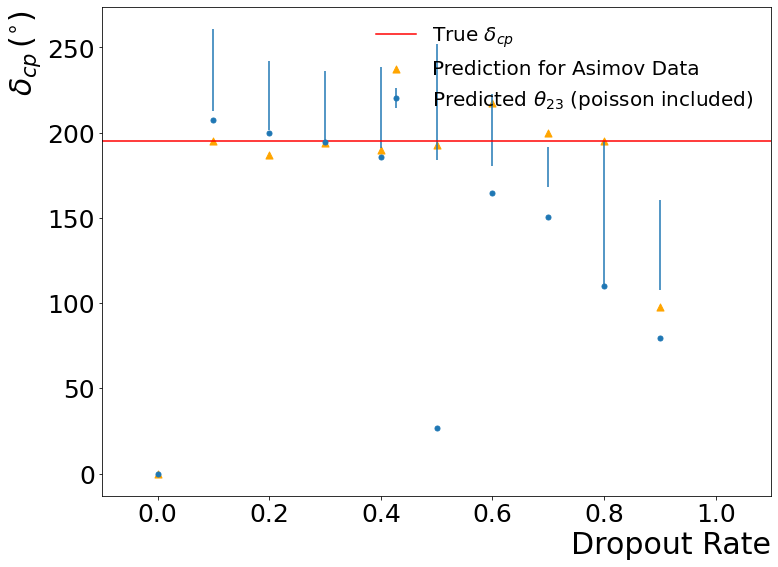

CPU times: user 252 ms, sys: 149 ms, total: 401 ms
Wall time: 252 ms


In [17]:
%%time

fig, ax = plt.subplots(1,1, figsize=(12,9))


dropuot_rate = np.linspace(0,1,11)[:-1]
prediction_asimov = [delta_resolution[dropuot_rate]["asimov"] for dropuot_rate in delta_resolution]
best_fit = [delta_resolution[dropuot_rate]["best_fit"] for dropuot_rate in delta_resolution]
p_yerr = np.array([delta_resolution[dropuot_rate]["p_yerr"] for dropuot_rate in delta_resolution]) - np.array(best_fit)
n_yerr = np.array(best_fit) - np.array([delta_resolution[dropuot_rate]["n_yerr"] for dropuot_rate in delta_resolution])
uncertainty = [n_yerr, p_yerr]

plt.scatter(dropuot_rate, prediction_asimov, color='orange', marker = "^", s=50, label="Prediction for Asimov Data")
plt.errorbar(dropuot_rate, best_fit, yerr=uncertainty, fmt='o',ms=5, label="Predicted $\\theta_{23}$ (poisson included)")
plt.axhline(y=195.00 , color='r', linestyle='-', label="True $\delta_{cp}$")


ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((-0.1,1.1))
# plt.ylim((44, 50))
plt.xlabel("Dropout Rate", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("$\delta_{cp}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
 


plt.show()

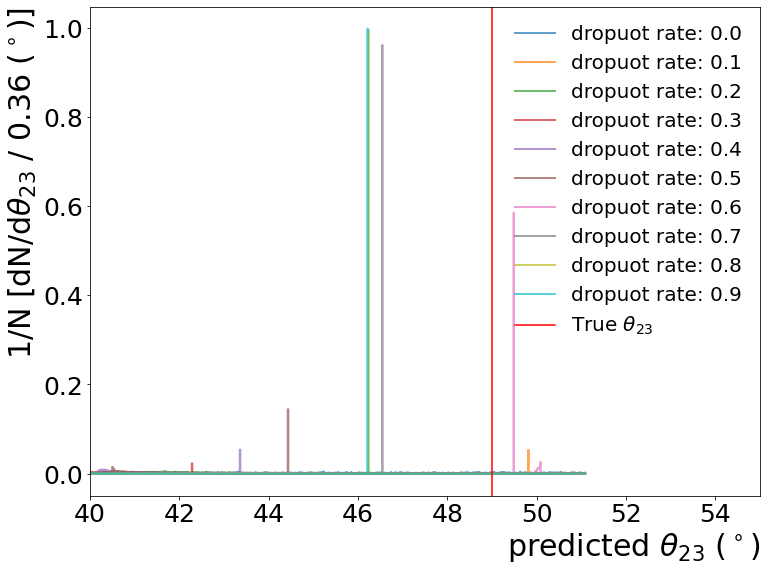

CPU times: user 316 ms, sys: 158 ms, total: 474 ms
Wall time: 313 ms


In [18]:
%%time
fig, ax = plt.subplots(1,1, figsize=(12,9))

for i in range(10):
    hist, bins = theta23_resolution["dropuot_rate_"+str(i)]["hist"], bins_theta23
#     hist, bins = theta23_resolution["dropuot_rate_"+str(i)]["hist"], np.linspace(38.9, 51.1, 1000)
    
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
    #          hist.astype(np.float32) ,
             where='mid',
             linewidth=2, 
             alpha=0.7,
             label="dropuot rate: {}".format(i/10)
            )
    
    
plt.axvline(x=49.00 , color='r', linestyle='-', label="True $\\theta_{23}$")

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((40,55))
# plt.ylim((0., 0.18))
plt.xlabel("predicted $\\theta_{23}$ ($^\circ$)", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("1/N [dN/d$\\theta_{23}$ / 0.36 ($^\circ$)]", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="upper right",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
    


plt.show()

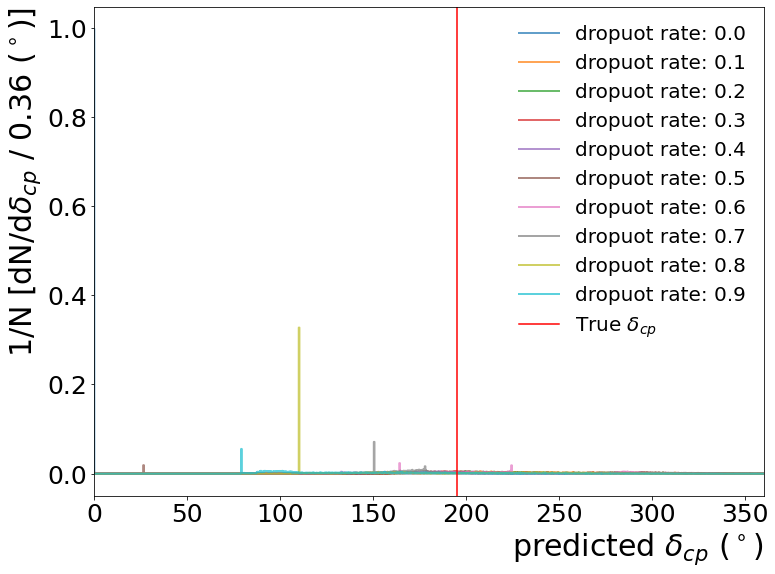

CPU times: user 286 ms, sys: 178 ms, total: 464 ms
Wall time: 300 ms


In [19]:
%%time
fig, ax = plt.subplots(1,1, figsize=(12,9))

for i in range(10):
    hist, bins = delta_resolution["dropuot_rate_"+str(i)]["hist"], bins_delta
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
    #          hist.astype(np.float32) ,
             where='mid',
             linewidth=2, 
             alpha=0.7,
             label="dropuot rate: {}".format(i/10)
            )

plt.axvline(x=195.00 , color='r', linestyle='-', label="True $\delta_{cp}$")
    
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0,360))
# plt.ylim((0., 0.18))
plt.xlabel("predicted $\delta_{cp}$ ($^\circ$)", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("1/N [dN/d$\delta_{cp}$ / 0.36 ($^\circ$)]", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="upper right",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
    


plt.show()